This notebook demonstrates the process of imputation and applying the Horvath model for the microarray data.

In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
eps_methyLImp = 4000
eps_nbp1 = eps_nbp2 = 10000

In [3]:
real_age = np.array([57, 75, 57, 68, 88, 76, 52, 56, 55, 67, 68, 63, 60, 63, 58, 68, 53, 61, 61, 60, 62, 63, 63, 61])
def metrics(predicted_age):
    diffs = predicted_age[12:] - real_age[12:]
    print(f"rmse: {(diffs ** 2).mean() ** 0.5}, mae: {np.abs(diffs).mean()}")

def add_metrics(predicted_age, rmse_lst, mae_lst):
    diffs = predicted_age[12:] - real_age[12:]
    rmse_lst.append((diffs ** 2).mean() ** 0.5)
    mae_lst.append(np.abs(diffs).mean())

In [4]:
data  = pd.read_csv('../data/microarray_dataset_with_cancer_chr_pos_preprocessed.tsv', sep='\t')
data

,chromosome,position,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample15,sample16,sample17,sample18,sample19,sample20,sample21,sample22,sample23,sample24
0,chr1,15865,82.045,82.856,82.837,87.850,90.361,78.916,76.064,72.616,...,83.194,77.637,90.263,72.411,81.641,81.562,86.460,84.858,85.185,85.640
1,chr1,18827,55.399,51.467,50.406,52.594,55.159,54.301,56.033,49.333,...,67.143,76.867,70.885,72.977,66.824,58.117,61.823,67.223,75.180,77.534
2,chr1,29407,4.354,4.437,5.099,3.634,3.011,3.482,5.130,3.310,...,6.869,2.641,3.964,1.892,4.096,4.569,5.540,6.707,5.535,4.048
3,chr1,29425,4.691,4.901,4.122,4.575,5.550,3.813,4.643,5.072,...,4.321,3.644,11.370,6.227,6.575,8.500,12.517,11.136,6.952,5.986
4,chr1,29435,2.219,2.426,3.626,3.880,2.693,2.963,5.088,3.022,...,2.706,2.922,5.984,3.648,2.941,2.821,3.149,3.688,NaN,3.779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485572,chrY,27009430,28.946,0.000,3.568,69.084,73.191,73.146,NaN,74.637,...,79.552,86.449,76.814,70.504,57.672,NaN,NaN,NaN,37.405,6.296
485573,chrY,27210334,54.998,54.106,46.527,67.700,15.278,69.349,58.863,72.854,...,58.997,58.362,68.094,63.389,58.114,44.422,47.170,50.340,84.172,63.176
485574,chrY,28555536,31.720,32.511,27.565,85.546,88.500,92.555,NaN,83.337,...,86.957,86.517,85.428,80.455,49.904,44.764,29.061,34.681,58.534,32.206
485575,chrY,28555550,NaN,25.076,12.332,91.528,93.369,92.264,33.389,82.597,...,94.276,90.840,91.211,94.290,49.088,36.958,30.619,39.546,33.344,12.321


In [5]:
map_data = pd.read_csv("../data/hm27.hg19.manifest_preprocessed.bed", sep='\t')
get_chr, get_pos = utils.get_marker_to_chr_and_pos(map_data)

horvath_data = pd.read_csv("../data/gb-2013-14-10-r115-S3_preprocessed.csv", sep='\t')
horvath_chr = horvath_data['marker'].apply(get_chr)
horvath_pos = horvath_data['marker'].apply(get_pos)

In [6]:
slices = []

chromosome_coords = utils.get_chromosome_coords(data.chromosome)
positions = data.position.values

for c, p in zip(horvath_chr, horvath_pos):
    i, j = chromosome_coords[c]
    ind = np.searchsorted(positions[i:j], p)
    if p <= positions[i + ind] <= p + 1 :
        slices.append((ind + i, ind + i + 1))
    else:
        l, r = utils.find_slice(p, eps_nbp2, positions[i:j])
        slices.append((l + i, r + i))

rows_to_impute = np.zeros(len(data), dtype=bool)
for l, r in slices:
    rows_to_impute[l:r] = True

def impute_rows(imputed_data):
    rows = []
    for i, j in slices:
        rows.append(np.mean(imputed_data[i:j], axis=0))
    return np.array(rows)

In [7]:
imputed_methyLImp = utils.methyLImp(data, rows_to_impute, eps_methyLImp)
horvath_features_methyLImp_nbp = impute_rows(imputed_methyLImp)
predicted_age_methyLImp_nbp = utils.apply_horvath(horvath_features_methyLImp_nbp.T / 100, horvath_data.coefs.values)

imputed_nbp = utils.impute_nbp(data, eps_nbp1, rows_to_impute[:, None] & np.isnan(data.values[:, 2:].astype(np.float64)))
imputed_nbp = imputed_nbp.values[:, 2:]
horvath_features_nbp_nbp = impute_rows(imputed_nbp)
predicted_age_nbp_nbp = utils.apply_horvath(horvath_features_nbp_nbp.T / 100, horvath_data.coefs.values)

imputed_people_mean = utils.impute_people_mean(data, rows_to_impute[:, None] & np.isnan(data.values[:, 2:].astype(np.float64)))
imputed_people_mean = imputed_people_mean.values[:, 2:]
horvath_features_people_mean_nbp = impute_rows(imputed_people_mean)
predicted_age_people_mean_nbp = utils.apply_horvath(horvath_features_people_mean_nbp.T / 100, horvath_data.coefs.values)

imputed_cytosine_mean = utils.impute_cytosine_mean(data, rows_to_impute[:, None] & np.isnan(data.values[:, 2:].astype(np.float64)))
imputed_cytosine_mean = imputed_cytosine_mean.values[:, 2:]
horvath_features_cytosine_mean_nbp = impute_rows(imputed_cytosine_mean)
predicted_age_cytosine_mean_nbp = utils.apply_horvath(horvath_features_cytosine_mean_nbp.T / 100, horvath_data.coefs.values)

100%|██████████| 7/7 [00:00<00:00, 7881.91it/s]


In [8]:
print("Initial data\n\n")

print("methyLImp + nbp")
metrics(predicted_age_methyLImp_nbp)
print()

print("nbp + nbp")
metrics(predicted_age_nbp_nbp)
print()

print("people mean + nbp")
metrics(predicted_age_people_mean_nbp)
print()

print("cytosine mean + nbp")
metrics(predicted_age_cytosine_mean_nbp)

Initial data


methyLImp + nbp
rmse: 8.956986420872896, mae: 7.791967058334048

nbp + nbp
rmse: 8.944470705548891, mae: 7.77875552911145

people mean + nbp
rmse: 8.960796013070714, mae: 7.8884055810383344

cytosine mean + nbp
rmse: 8.965428700629394, mae: 7.790794514111778


In [12]:
rmse_lst = []
mae_lst = []

for _ in range(10):
    new_data = data.drop(np.random.choice([t[0] for t in slices], size=180, replace=False)).reset_index().drop(["index"], axis=1)
    new_slices = []

    chromosome_coords = utils.get_chromosome_coords(new_data.chromosome)
    positions = new_data.position.values

    for c, p in zip(horvath_chr, horvath_pos):
        i, j = chromosome_coords[c]
        ind = np.searchsorted(positions[i:j], p)
        if p <= positions[i + ind] <= p + 1 :
            new_slices.append((ind + i, ind + i + 1))
        else:
            l, r = utils.find_slice(p, eps_nbp2, positions[i:j])
            new_slices.append((l + i, r + i))

    rows_to_impute = np.zeros(len(new_data), dtype=bool)
    for l, r in new_slices:
        rows_to_impute[l:r] = True

    def impute_rows(imputed_data):
        rows = []
        for i, j in new_slices:
            rows.append(np.mean(imputed_data[i:j], axis=0))
        return np.array(rows)
    
    imputed_methyLImp = utils.methyLImp(new_data, rows_to_impute, eps_methyLImp)
    horvath_features_methyLImp_nbp = impute_rows(imputed_methyLImp)
    predicted_age_methyLImp_nbp = utils.apply_horvath(horvath_features_methyLImp_nbp.T / 100, horvath_data.coefs.values)

    imputed_nbp = utils.impute_nbp(new_data, eps_nbp1, rows_to_impute[:, None] & np.isnan(new_data.values[:, 2:].astype(np.float64)))
    imputed_nbp = imputed_nbp.values[:, 2:]
    horvath_features_nbp_nbp = impute_rows(imputed_nbp)
    predicted_age_nbp_nbp = utils.apply_horvath(horvath_features_nbp_nbp.T / 100, horvath_data.coefs.values)

    imputed_people_mean = utils.impute_people_mean(new_data, rows_to_impute[:, None] & np.isnan(new_data.values[:, 2:].astype(np.float64)))
    imputed_people_mean = imputed_people_mean.values[:, 2:]
    horvath_features_people_mean_nbp = impute_rows(imputed_people_mean)
    predicted_age_people_mean_nbp = utils.apply_horvath(horvath_features_people_mean_nbp.T / 100, horvath_data.coefs.values)

    imputed_cytosine_mean = utils.impute_cytosine_mean(new_data, rows_to_impute[:, None] & np.isnan(new_data.values[:, 2:].astype(np.float64)))
    imputed_cytosine_mean = imputed_cytosine_mean.values[:, 2:]
    horvath_features_cytosine_mean_nbp = impute_rows(imputed_cytosine_mean)
    predicted_age_cytosine_mean_nbp = utils.apply_horvath(horvath_features_cytosine_mean_nbp.T / 100, horvath_data.coefs.values)

    add_metrics(predicted_age_methyLImp_nbp, rmse_lst, mae_lst)
    add_metrics(predicted_age_nbp_nbp, rmse_lst, mae_lst)
    add_metrics(predicted_age_people_mean_nbp, rmse_lst, mae_lst)
    add_metrics(predicted_age_cytosine_mean_nbp, rmse_lst, mae_lst)

100%|██████████| 186/186 [00:00<00:00, 11571.52it/s]


In [13]:
print("Dropped and then imputed back 180 horvath rows\n\n")

for method, rmse_seq, mae_seq in zip(
    ["methyLImp + nbp", "nbp + nbp", "people mean + nbp", "cytosine mean + nbp"],
    np.reshape(rmse_lst, (10, 4)).T,
    np.reshape(mae_lst, (10, 4)).T
    ):
    print(method)
    print(f"rmse: {np.mean(rmse_seq)} +/- {np.std(rmse_seq)}")
    print(f"mae: {np.mean(mae_seq)} +/- {np.std(mae_seq)}\n")

Dropped and then imputed back 180 horvath rows


methyLImp + nbp
rmse: 10.857162019704024 +/- 5.613912408247698
mae: 10.230004126198903 +/- 5.872845584802788

nbp + nbp
rmse: 10.971353170776444 +/- 5.646444271542986
mae: 10.314821804831162 +/- 5.855400099053185

people mean + nbp
rmse: 11.052183399073012 +/- 5.649504636880672
mae: 10.362693974743298 +/- 5.846993518309055

cytosine mean + nbp
rmse: 10.860869520024947 +/- 5.614643610265602
mae: 10.233143119962255 +/- 5.869928612212385



[12.757949   16.57781633  4.16549995  9.15107283 11.43199343  7.20385582
 14.23178827  4.53614548 22.71303624  5.80246285]
[13.22007703 17.11475586  4.34809841  9.06114678 11.4924337   7.22257691
 13.98323319  4.52981551 22.75246383  5.98893047]


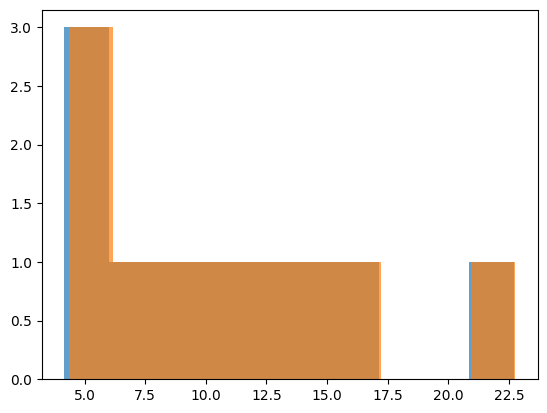

In [14]:
for lst in np.reshape(rmse_lst, (10, 4)).T[:2]:
    print(lst)
    plt.hist(lst, alpha=0.7)

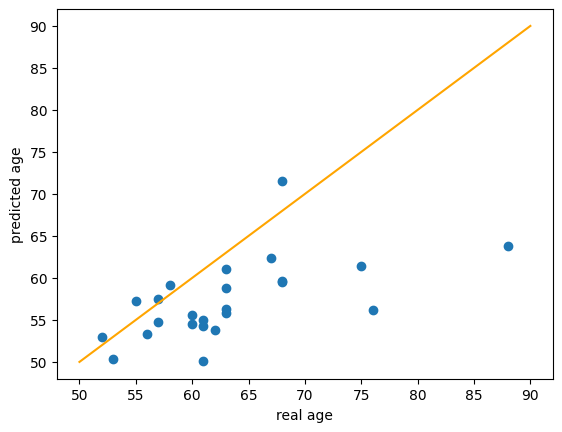

In [16]:
plt.scatter(real_age, predicted_age_methyLImp_nbp)
plt.xlabel("real age")
plt.ylabel("predicted age")
plt.plot(np.linspace(50, 90, 1000), np.linspace(50, 90, 1000), c="orange")

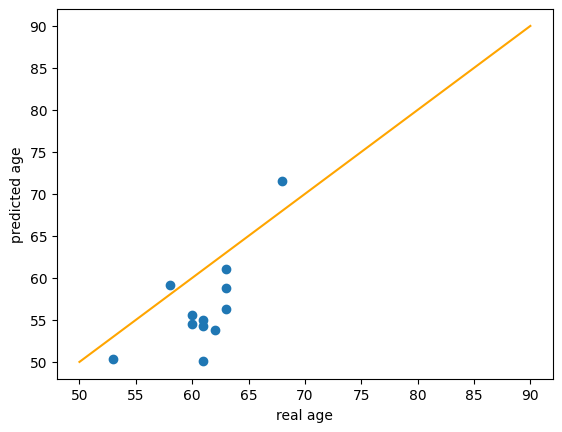

In [17]:
plt.scatter(real_age[12:], predicted_age_methyLImp_nbp[12:])
plt.xlabel("real age")
plt.ylabel("predicted age")
plt.plot(np.linspace(50, 90, 1000), np.linspace(50, 90, 1000), c="orange")

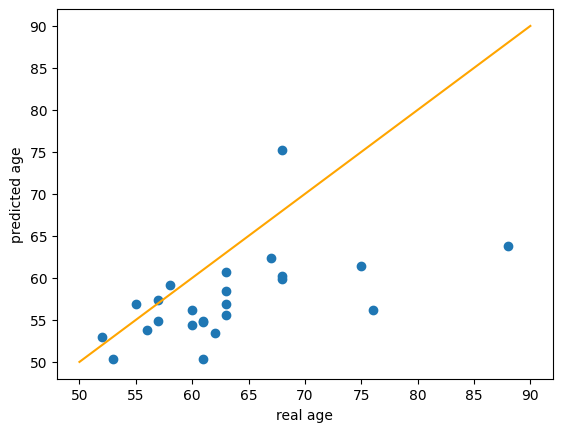

In [18]:
plt.scatter(real_age, predicted_age_nbp_nbp)
plt.xlabel("real age")
plt.ylabel("predicted age")
plt.plot(np.linspace(50, 90, 1000), np.linspace(50, 90, 1000), c="orange")

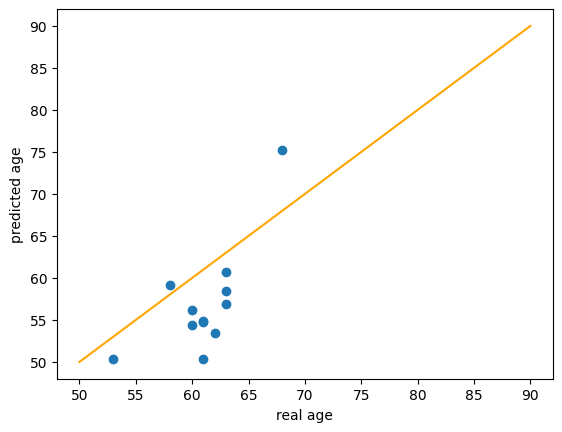

In [19]:
plt.scatter(real_age[12:], predicted_age_nbp_nbp[12:])
plt.xlabel("real age")
plt.ylabel("predicted age")
plt.plot(np.linspace(50, 90, 1000), np.linspace(50, 90, 1000), c="orange")